# OOP Implementation

In [1]:
import sys
from pathlib import Path

current = Path.cwd()
for parent in [current, *current.parents]:
    if (parent / '_config.yml').exists():
        project_root = parent
        break
else:
    project_root = Path.cwd().parent.parent

sys.path.insert(0, str(project_root))

from shared import thinkpython, diagram, jupyturtle, download

sys.modules['thinkpython'] = thinkpython
sys.modules['diagram'] = diagram
sys.modules['jupyturtle'] = jupyturtle
sys.modules['download'] = download

## Polymorphism

In the previous example, we invoked the `draw` method on two `Line` objects and two `Rectangle` objects.
We can do the same thing more concisely by making a list of objects.

In [2]:
# Setup: define classes and instances from the previous notebook
from copy import copy, deepcopy
from jupyturtle import make_turtle, jumpto, moveto


class Point:
    """Represents a point in 2-D space."""

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return f'Point({self.x}, {self.y})'

    def __eq__(self, other):
        return (self.x == other.x) and (self.y == other.y)

    def translate(self, dx, dy):
        self.x += dx
        self.y += dy

    def translated(self, dx=0, dy=0):
        point = copy(self)
        point.translate(dx, dy)
        return point


class Line:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2

    def __str__(self):
        return f'Line({self.p1}, {self.p2})'

    def draw(self):
        jumpto(self.p1.x, self.p1.y)
        moveto(self.p2.x, self.p2.y)


class Rectangle:
    """Represents a rectangle.

    attributes: width, height, corner.
    """

    def __init__(self, width, height, corner):
        self.width = width
        self.height = height
        self.corner = corner

    def __str__(self):
        return f'Rectangle({self.width}, {self.height}, {self.corner})'

    def make_points(self):
        p1 = self.corner
        p2 = p1.translated(self.width, 0)
        p3 = p2.translated(0, self.height)
        p4 = p3.translated(-self.width, 0)
        return p1, p2, p3, p4

    def make_lines(self):
        p1, p2, p3, p4 = self.make_points()
        return Line(p1, p2), Line(p2, p3), Line(p3, p4), Line(p4, p1)

    def draw(self):
        lines = self.make_lines()
        for line in lines:
            line.draw()

    def grow(self, dwidth, dheight):
        self.width += dwidth
        self.height += dheight

    def translate(self, dx, dy):
        self.corner.translate(dx, dy)


# Create instances used in the Polymorphism examples
start = Point(0, 0)
end1 = copy(start)
end1.translate(300, 0)
end2 = start.translated(0, 150)

line1 = Line(start, end1)
line2 = Line(start, end2)

corner = Point(20, 20)
box3 = Rectangle(100, 50, corner)
box4 = deepcopy(box3)


In [3]:
shapes = [line1, line2, box3, box4]

The elements of this list are different types, but they all provide a `draw` method, so we can loop through the list and invoke `draw` on each one.

In [4]:
make_turtle()

for shape in shapes:
    shape.draw()

The first and second time through the loop, `shape` refers to a `Line` object, so when `draw` is invoked, the method that runs is the one defined in the `Line` class.

The third and fourth time through the loop, `shape` refers to a `Rectangle` object, so when `draw` is invoked, the method that runs is the one defined in the `Rectangle` class.

In a sense, each object knows how to draw itself.
This feature is called **polymorphism**.
The word comes from Greek roots that mean "many shaped".
In object-oriented programming, polymorphism is the ability of different types to provide the same methods, which makes it possible to perform many computations -- like drawing shapes -- by invoking the same method on different types of objects.

As an exercise at the end of this chapter, you'll define a new class that represents a circle and provides a `draw` method.
Then you can use polymorphism to draw lines, rectangles, and circles.

## Inheritance

The language feature most often associated with object-oriented programming is **inheritance**.
Inheritance is the ability to define a new class that is a modified version of an existing class.
In this chapter I demonstrate inheritance using classes that represent playing cards, decks of cards, and poker hands.
If you don't play poker, don't worry -- I'll tell you what you need to know.

In [5]:
import thinkpython, diagram, jupyturtle

## Representing cards

There are 52 playing cards in a standard deck -- each of them belongs to one of four suits and one of thirteen ranks. 
The suits are Spades, Hearts, Diamonds, and Clubs.
The ranks are Ace, 2, 3, 4, 5, 6, 7, 8, 9, 10, Jack, Queen, and King.
Depending on which game you are playing, an Ace can be higher than King or lower than 2.

If we want to define a new object to represent a playing card, it is obvious what the attributes should be: `rank` and `suit`.
It is less obvious what type the attributes should be.
One possibility is to use strings like `'Spade'` for suits and `'Queen'` for ranks.
A problem with this implementation is that it would not be easy to compare cards to see which had a higher rank or suit.

An alternative is to use integers to **encode** the ranks and suits.
In this context, "encode" means that we are going to define a mapping between numbers and suits, or between numbers and ranks.
This kind of encoding is not meant to be a secret (that would be "encryption").

For example, this table shows the suits and the corresponding integer codes:


| Suit | Code |
| --- | --- |
|  Spades     |   3  |
|  Hearts     |   2  |
|  Diamonds   |   1  |
|  Clubs      |   0  |

With this encoding, we can compare suits by comparing their codes.

To encode the ranks, we'll use the integer `2` to represent the rank `2`, `3` to represent `3`, and so on up to `10`.
The following table shows the codes for the face cards.

  
| Rank | Code |
| --- | --- |
|  Jack     |   11  |
|  Queen   |   12  |
|  King      |   13  |

And we can use either `1` or `14` to represent an Ace, depending on whether we want it to be considered lower or higher than the other ranks.

To represent these encodings, we will use two lists of strings, one with the names of the suits and the other with the names of the ranks.

Here's a definition for a class that represents a playing card, with these lists of strings as **class variables**, which are variables defined inside a class definition, but not inside a method.

In [6]:
class Card:
    """Represents a standard playing card."""

    suit_names = ['Clubs', 'Diamonds', 'Hearts', 'Spades']
    rank_names = [None, 'Ace', '2', '3', '4', '5', '6', '7', 
                  '8', '9', '10', 'Jack', 'Queen', 'King', 'Ace']

The first element of `rank_names` is `None` because there is no card with rank zero. By including `None` as a place-keeper, we get a list with the nice property that the index `2` maps to the string `'2'`, and so on.

Class variables are associated with the class, rather than an instance of the class, so we can access them like this.

In [7]:
Card.suit_names

['Clubs', 'Diamonds', 'Hearts', 'Spades']

We can use `suit_names` to look up a suit and get the corresponding string.

In [8]:
Card.suit_names[0]

'Clubs'

And `rank_names` to look up a rank.

In [9]:
Card.rank_names[11]

'Jack'

## Card attributes

Here's an `__init__` method for the `Card` class -- it takes `suit` and `rank` as parameters and assigns them to attributes with the same names.

In [10]:
%%add_method_to Card

    def __init__(self, suit, rank):
        self.suit = suit
        self.rank = rank

Now we can create a `Card` object like this.

In [11]:
queen = Card(1, 12)

We can use the new instance to access the attributes.

In [12]:
queen.suit, queen.rank

(1, 12)

It is also legal to use the instance to access the class variables.

In [13]:
queen.suit_names

['Clubs', 'Diamonds', 'Hearts', 'Spades']

But if you use the class, it is clearer that they are class variables, not attributes.

## Printing cards

Here's a `__str__` method for `Card` objects.

In [14]:
%%add_method_to Card

    def __str__(self):
        rank_name = Card.rank_names[self.rank]
        suit_name = Card.suit_names[self.suit]
        return f'{rank_name} of {suit_name}' 

When we print a `Card`, Python calls the `__str__` method to get a human-readable representation of the card.

In [15]:
print(queen)

Queen of Diamonds


The following is a diagram of the `Card` class object and the Card instance.
`Card` is a class object, so its type is `type`.
`queen` is an instance of `Card`, so its type is `Card`.
To save space, I didn't draw the contents of `suit_names` and `rank_names`.

In [16]:
from diagram import Binding, Value, Frame, Stack

bindings = [Binding(Value(name), draw_value=False)
            for name in ['suit_names', 'rank_names']]
    
frame1 = Frame(bindings, name='type', dy=-0.5, offsetx=0.77)
binding1 = Binding(Value('Card'), frame1)

bindings = [Binding(Value(name), Value(value))
            for name, value in zip(['suit', 'rank'], [1, 11])]
    
frame2 = Frame(bindings, name='Card', dy=-0.3, offsetx=0.33)
binding2 = Binding(Value('queen'), frame2)

stack = Stack([binding1, binding2], dy=-1.2)

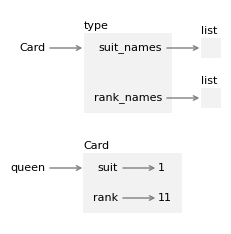

In [17]:
from diagram import diagram, Bbox, make_list, adjust

width, height, x, y = [2.11, 2.14, 0.35, 1.76]
ax = diagram(width, height)
bbox = stack.draw(ax, x, y)

value = make_list([])
bbox2 = value.draw(ax, x+1.66, y)

value = make_list([])
bbox3 = value.draw(ax, x+1.66, y-0.5)

bbox = Bbox.union([bbox, bbox2, bbox3])
#adjust(x, y, bbox)

Every `Card` instance has its own `suit` and `rank` attributes, but there is only one `Card` class object, and only one copy of the class variables `suit_names` and `rank_names`.

## Comparing cards

Suppose we create a second `Card` object with the same suit and rank.

In [18]:
queen2 = Card(1, 12)
print(queen2)

Queen of Diamonds


If we use the `==` operator to compare them, it checks whether `queen` and `queen2` refer to the same object.

In [19]:
queen == queen2

False

They don't, so it returns `False`.
We can change this behavior by defining the special method `__eq__`.

In [20]:
%%add_method_to Card

    def __eq__(self, other):
        return self.suit == other.suit and self.rank == other.rank

`__eq__` takes two `Card` objects as parameters and returns `True` if they have the same suit and rank, even if they are not the same object.
In other words, it checks whether they are equivalent, even if they are not identical.

When we use the `==` operator with `Card` objects, Python calls the `__eq__` method.

In [21]:
queen == queen2

True

As a second test, let's create a card with the same suit and a different rank.

In [22]:
six = Card(1, 6)
print(six)

6 of Diamonds


We can confirm that `queen` and `six` are not equivalent.

In [23]:
queen == six

False

If we use the `!=` operator, Python invokes a special method called `__ne__`, if it exists.
Otherwise it invokes`__eq__` and inverts the result -- so if `__eq__` returns `True`, the result of the `!=` operator is `False`.

In [24]:
queen != queen2

False

In [25]:
queen != six

True

Now suppose we want to compare two cards to see which is bigger.
If we use one of the relational operators, we get a `TypeError`.

In [26]:
%%expect TypeError

queen < queen2

TypeError: '<' not supported between instances of 'Card' and 'Card'

To change the behavior of the `<` operator, we can define a special method called `__lt__`, which is short for "less than".
For the sake of this example, let's assume that suit is more important than rank -- so all Spades outrank all Hearts, which outrank all Diamonds, and so on.
If two cards have the same suit, the one with the higher rank wins.

To implement this logic, we'll use the following method, which returns a tuple containing a card's suit and rank, in that order.

In [27]:
%%add_method_to Card

    def to_tuple(self):
        return (self.suit, self.rank)

We can use this method to write `__lt__`.

In [28]:
%%add_method_to Card

    def __lt__(self, other):
        return self.to_tuple() < other.to_tuple()

Tuple comparison compares the first elements from each tuple, which represent the suits.
If they are the same, it compares the second elements, which represent the ranks.

Now if we use the `<` operator, it invokes the `__lt__` method.

In [29]:
six < queen

True

If we use the `>` operator, it invokes a special method called `__gt__`, if it exists.
Otherwise it invokes `__lt__` with the arguments in the opposite order.

In [30]:
queen < queen2

False

In [31]:
queen > queen2

False

Finally, if we use the `<=` operator, it invokes a special method called `__le__`.

In [32]:
%%add_method_to Card

    def __le__(self, other):
        return self.to_tuple() <= other.to_tuple()

So we can check whether one card is less than or equal to another.

In [33]:
queen <= queen2

True

In [34]:
queen <= six

False

If we use the `>=` operator, it uses `__ge__` if it exists. Otherwise, it invokes `__le__` with the arguments in the opposite order.

In [35]:
queen >= six

True

As we have defined them, these methods are complete in the sense that we can compare any two `Card` objects, and consistent in the sense that results from different operators don't contradict each other.
With these two properties, we can say that `Card` objects are **totally ordered**.
And that means, as we'll see soon, that they can be sorted.

## Decks

Now that we have objects that represent cards, let's define objects that represent decks.
The following is a class definition for `Deck` with
an `__init__` method takes a list of `Card` objects as a parameter and assigns it to an attribute called `cards`.

In [36]:
class Deck:

    def __init__(self, cards):
        self.cards = cards

To create a list that contains the 52 cards in a standard deck, we'll use the following static method.

In [37]:
%%add_method_to Deck

    def make_cards():
        cards = []
        for suit in range(4):
            for rank in range(2, 15):
                card = Card(suit, rank)
                cards.append(card)
        return cards

In `make_cards`, the outer loop enumerates the suits from `0` to `3`.
The inner loop enumerates the ranks from `2` to `14` -- where `14` represents an Ace that outranks a King.
Each iteration creates a new `Card` with the current suit and rank, and appends it to `cards`.

Here's how we make a list of cards and a `Deck` object that contains it.

In [38]:
cards = Deck.make_cards()
deck = Deck(cards)
len(deck.cards)

52

It contains 52 cards, as intended.

## Printing the deck

Here is a `__str__` method for `Deck`.

In [39]:
%%add_method_to Deck

    def __str__(self):
        res = []
        for card in self.cards:
            res.append(str(card))
        return '\n'.join(res)

This method demonstrates an efficient way to accumulate a large string -- building a list of strings and then using the string method `join`. 

We'll test this method with a deck that only contains two cards.

In [40]:
small_deck = Deck([queen, six])

If we call `str`, it invokes `__str__`.

In [41]:
str(small_deck)

'Queen of Diamonds\n6 of Diamonds'

When Jupyter displays a string, it shows the "representational" form of the string, which represents a newline with the sequence `\n`.

However, if we print the result, Jupyter shows the "printable" form of the string, which prints the newline as whitespace.

In [42]:
print(small_deck)

Queen of Diamonds
6 of Diamonds


So the cards appear on separate lines.

## Add, remove, shuffle and sort

To deal cards, we would like a method that removes a card from the deck
and returns it. The list method `pop` provides a convenient way to do
that.

In [43]:
%%add_method_to Deck

    def take_card(self):
        return self.cards.pop()

Here's how we use it.

In [44]:
card = deck.take_card()
print(card)

Ace of Spades


We can confirm that there are `51` cards left in the deck.

In [45]:
len(deck.cards)

51

To add a card, we can use the list method `append`.

In [46]:
%%add_method_to Deck

    def put_card(self, card):
        self.cards.append(card)

As an example, we can put back the card we just popped.

In [47]:
deck.put_card(card)
len(deck.cards)

52

To shuffle the deck, we can use the `shuffle` function from the `random` module:

In [48]:
import random

In [49]:
# This cell initializes the random number generator so we
# always get the same results.

random.seed(3)

In [50]:
%%add_method_to Deck
            
    def shuffle(self):
        random.shuffle(self.cards)

If we shuffle the deck and print the first few cards, we can see that they are in no apparent order.

In [51]:
deck.shuffle()
for card in deck.cards[:4]:
    print(card)

2 of Diamonds
4 of Hearts
5 of Clubs
8 of Diamonds


To sort the cards, we can use the list method `sort`, which sorts the elements "in place" -- that is, it modifies the list rather than creating a new list.

In [52]:
%%add_method_to Deck
            
    def sort(self):
        self.cards.sort()

When we invoke `sort`, it uses the `__lt__` method to compare cards.

In [53]:
deck.sort()

If we print the first few cards, we can confirm that they are in increasing order.

In [54]:
for card in deck.cards[:4]:
    print(card)

2 of Clubs
3 of Clubs
4 of Clubs
5 of Clubs


In this example, `Deck.sort` doesn't do anything other than invoke `list.sort`.
Passing along responsibility like this is called **delegation**.

## Parents and children

Inheritance is the ability to define a new class that is a modified version of an existing class.
As an example, let's say we want a class to represent a "hand", that is, the cards held by one player.

* A hand is similar to a deck -- both are made up of a collection of cards, and both require operations like adding and removing cards.

* A hand is also different from a deck -- there are operations we want for hands that don't make sense for a deck. For example, in poker we might compare two hands to see which one wins. In bridge, we might compute a score for a hand in order to make a bid.

This relationship between classes -- where one is a specialized version of another -- lends itself to inheritance. 

To define a new class that is based on an existing class, we put the name of the existing class in parentheses.

In [55]:
class Hand(Deck):
    """Represents a hand of playing cards."""

This definition indicates that `Hand` inherits from `Deck`, which means that `Hand` objects can access methods defined in `Deck`, like `take_card` and `put_card`.

`Hand` also inherits `__init__` from `Deck`, but if we define `__init__` in the `Hand` class, it overrides the one in the `Deck` class.

In [56]:
%%add_method_to Hand

    def __init__(self, label=''):
        self.label = label
        self.cards = []

This version of `__init__` takes an optional string as a parameter, and always starts with an empty list of cards.
When we create a `Hand`, Python invokes this method, not the one in `Deck` -- which we can confirm by checking that the result has a `label` attribute.

In [57]:
hand = Hand('player 1')
hand.label

'player 1'

To deal a card, we can use `take_card` to remove a card from a `Deck`, and `put_card` to add the card to a `Hand`.

In [58]:
deck = Deck(cards)
card = deck.take_card()
hand.put_card(card)
print(hand)

Ace of Spades


Let's encapsulate this code in a `Deck` method called `move_cards`.

In [59]:
%%add_method_to Deck

    def move_cards(self, other, num):
        for i in range(num):
            card = self.take_card()
            other.put_card(card)

This method is polymorphic -- that is, it works with more than one type: `self` and `other` can be either a `Hand` or a `Deck`.
So we can use this method to deal a card from `Deck` to a `Hand`, from one `Hand` to another, or from a `Hand` back to a `Deck`.

When a new class inherits from an existing one, the existing one is called the **parent** and the new class is called the **child**. In general:

* Instances of the child class should have all of the attributes of the parent class, but they can have additional attributes.

* The child class should have all of the methods of the parent class, but it can have additional methods.

* If a child class overrides a method from the parent class, the new method should take the same parameters and return a compatible result.

This set of rules is called the "Liskov substitution principle" after computer scientist Barbara Liskov.

If you follow these rules, any function or method designed to work with an instance of a parent class, like a `Deck`, will also work with instances of a child class, like `Hand`.
If you violate these rules, your code will collapse like a house of cards (sorry).

## Specialization

Let's make a class called `BridgeHand` that represents a hand in bridge -- a widely played card game.
We'll inherit from `Hand` and add a new method called `high_card_point_count` that evaluates a hand using a "high card point" method, which adds up points for the high cards in the hand.

Here's a class definition that contains as a class variable a dictionary that maps from card names to their point values.

In [60]:
class BridgeHand(Hand):
    """Represents a bridge hand."""

    hcp_dict = {
        'Ace': 4,
        'King': 3,
        'Queen': 2,
        'Jack': 1,
    }

Given the rank of a card, like `12`, we can use `Card.rank_names` to get the string representation of the rank, and then use `hcp_dict` to get its score.

In [61]:
rank = 12
rank_name = Card.rank_names[rank]
score = BridgeHand.hcp_dict.get(rank_name, 0)
rank_name, score

('Queen', 2)

The following method loops through the cards in a `BridgeHand` and adds up their scores.

In [62]:
%%add_method_to BridgeHand

    def high_card_point_count(self):
        count = 0
        for card in self.cards:
            rank_name = Card.rank_names[card.rank]
            count += BridgeHand.hcp_dict.get(rank_name, 0)
        return count

In [63]:
# This cell makes a fresh Deck and 
# initializes the random number generator

cards = Deck.make_cards()
deck = Deck(cards)
random.seed(3)

To test it, we'll deal a hand with five cards -- a bridge hand usually has thirteen, but it's  easier to test code with small examples.

In [64]:
hand = BridgeHand('player 2')

deck.shuffle()
deck.move_cards(hand, 5)
print(hand)

4 of Diamonds
King of Hearts
10 of Hearts
10 of Clubs
Queen of Diamonds


And here is the total score for the King and Queen.

In [65]:
hand.high_card_point_count()

5

`BridgeHand` inherits the variables and methods of `Hand` and adds a class variable and a method that are specific to bridge.
This way of using inheritance is called **specialization** because it defines a new class that is specialized for a particular use, like playing bridge.

## Debugging

Inheritance is a useful feature.
Some programs that would be repetitive without inheritance can be written more concisely with it.
Also, inheritance can facilitate code reuse, since you can customize the behavior of a parent class without having to modify it.
In some cases, the inheritance structure reflects the natural structure of the problem, which makes the design easier to understand.

On the other hand, inheritance can make programs difficult to read.
When a method is invoked, it is sometimes not clear where to find its definition -- the relevant code may be spread across several modules.

Any time you are unsure about the flow of execution through your program, the simplest solution is to add print statements at the beginning of the relevant methods.
If `Deck.shuffle` prints a message that says something like `Running Deck.shuffle`, then as the program runs it traces the flow of execution.

As an alternative, you could use the following function, which takes an object and a method name (as a string) and returns the class that provides the definition of the method.

In [66]:
def find_defining_class(obj, method_name):
    """Find the class where the given method is defined."""
    for typ in type(obj).mro():
        if method_name in vars(typ):
            return typ
    return f'Method {method_name} not found.'

`find_defining_class` uses the `mro` method to get the list of class objects (types) that will be searched for methods.
"MRO" stands for "method resolution order", which is the sequence of classes Python searches to "resolve" a method name -- that is, to find the function object the name refers to.

As an example, let's instantiate a `BridgeHand` and then find the defining class of `shuffle`.

In [67]:
hand = BridgeHand('player 3')
find_defining_class(hand, 'shuffle')

__main__.Deck

The `shuffle` method for the `BridgeHand` object is the one in `Deck`.